In [1]:
!pip install pyrsistent matplotlib numpy -q
!pip install wandb -qU
print("✅ Libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 72.6 MB/s eta 0:00:00
✅ Libraries installed!


In [2]:
import os
import sys

In [3]:
sys.path.append('/kaggle/input/senet-files')

In [4]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
from ai_pruning import AI
from evaluation_ai_star1 import SENET_AI_CONFIG
from game_state_pyrsistent import GameState
from board import create_initial_board
from rules_silent import apply_move, check_win
from sticks import throw_sticks
from datetime import datetime
import wandb

In [5]:
wandb.login(key="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")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eliasnadder (eliasnadder-liso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# إعدادات Kaggle
WORKING_DIR = "/kaggle/working"
CHECKPOINT_DIR = os.path.join(WORKING_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [7]:
# ✅ FIX: إعدادات محسّنة
POP_SIZE = 40
GENS = 50
MATCHES_PER_EVAL = 10
ELITE_SIZE = 4              # ✅ FIX: تقليل من 6
MUTATION_RATE = 0.4         # ✅ FIX: زيادة قليلاً
MAX_MOVES = 300
DIVERSITY_THRESHOLD = 2000  # ✅ FIX: جديد

In [8]:
DESIRED_CONFIG_KEYS = {
    'piece_off': 1200,
    'win_bonus': 20000,
    'progress_base': 85,
    'zone_multiplier': 1.8,
    'happiness_bonus': 150,
    'water_penalty': -300,
    'special_house': 100,
    'protection': 60,
    'block': 80,
    'attack': 60,
    'flexibility': 8,
    'isolated_penalty': 15
}

In [9]:
# ============================================================
# ✅ FIX: دوال مستقلة للـ multiprocessing
# هذه الدوال يجب أن تكون خارج الـ class ليعمل ProcessPoolExecutor
# ============================================================

def play_match_standalone(player_dna, opponent_dna, opponent_strength, max_moves=300):
    """
    ✅ FIX: دالة مستقلة للعب مباراة واحدة
    تُستدعى من ProcessPoolExecutor
    كل المعاملات تُمرر صراحة!
    """
    board = create_initial_board()
    
    ai_x = AI('X', depth=3, weights=player_dna)
    ai_o = AI('O', depth=3, weights=opponent_dna)
    
    current_player = 'X'
    move_count = 0
    state_history = {}
    
    while move_count < max_moves:
        roll = throw_sticks()
        
        if current_player == 'X':
            # اللاعب يلعب بكامل قوته دائماً
            state = GameState.from_board(board, 'X')
            move = ai_x.choose_best_move(state, roll)
        else:
            # ✅ FIX: الخصم المتكيف - يستخدم opponent_strength المُمررة
            state = GameState.from_board(board, 'O')
            
            if random.random() < opponent_strength:
                # يلعب بذكاء
                move = ai_o.choose_best_move(state, roll)
            else:
                # يلعب عشوائياً
                valid_moves = state.get_valid_moves(roll)
                move = random.choice(valid_moves) if valid_moves else None
        
        if move:
            board = apply_move(board, move[0], move[1])
            
            if check_win(board, current_player):
                return _extract_match_stats(board, current_player, move_count)
            
            board_key = tuple(board)
            state_history[board_key] = state_history.get(board_key, 0) + 1
            if state_history[board_key] >= 3:
                return _extract_match_stats(board, 'DRAW', move_count)
        
        current_player = 'O' if current_player == 'X' else 'X'
        move_count += 1
    
    # انتهى الوقت - تحديد الفائز بعدد القطع
    x_pieces = sum(1 for p in board if p == 'X')
    o_pieces = sum(1 for p in board if p == 'O')
    
    if x_pieces < o_pieces:
        winner = 'X'  # أقل قطع = أفضل (خرجت من اللوحة)
    elif o_pieces < x_pieces:
        winner = 'O'
    else:
        winner = 'DRAW'
    
    return _extract_match_stats(board, winner, move_count)


def _extract_match_stats(board, winner, moves):
    """✅ FIX: استخراج إحصائيات تفصيلية للـ Partial Credit"""
    x_positions = [i for i, p in enumerate(board) if p == 'X']
    o_positions = [i for i, p in enumerate(board) if p == 'O']
    
    x_remaining = len(x_positions)
    o_remaining = len(o_positions)
    
    # حساب التقدم
    x_avg = sum(x_positions) / len(x_positions) if x_positions else 29
    x_max = max(x_positions) if x_positions else 29
    
    return {
        'winner': winner,
        'moves': moves,
        'player_remaining': x_remaining,
        'opponent_remaining': o_remaining,
        'player_pieces_off': 7 - x_remaining,
        'opponent_pieces_off': 7 - o_remaining,
        'player_avg_progress': x_avg,
        'player_max_progress': x_max
    }


def evaluate_dna_worker(args):
    """
    ✅ FIX: Worker function للتقييم المتوازي
    كل المعاملات في tuple واحد
    """
    dna_id, dna, opponent_dna, opponent_strength, num_matches = args
    
    total_score = 0
    wins = 0
    
    for _ in range(num_matches):
        result = play_match_standalone(dna, opponent_dna, opponent_strength)
        
        # ✅ FIX: نظام نقاط محسّن مع Partial Credit
        if result['winner'] == 'X':
            total_score += 100
            wins += 1
            # مكافأة الفوز السريع
            efficiency_bonus = max(0, (MAX_MOVES - result['moves'])) * 0.15
            total_score += efficiency_bonus
        elif result['winner'] == 'DRAW':
            total_score += 35
        else:
            # حتى في الخسارة، نعطي نقاط!
            total_score += 0
        
        # ✅ FIX: Partial Credit - نقاط حتى بدون فوز!
        total_score += result['player_pieces_off'] * 15
        total_score += result['player_avg_progress'] * 2.0
        
        # الفرق في القطع المتبقية
        piece_advantage = result['opponent_remaining'] - result['player_remaining']
        total_score += piece_advantage * 10
        
        # مكافأة الوصول لمنطقة متقدمة
        if result['player_max_progress'] >= 25:
            total_score += 20
        if result['player_max_progress'] >= 28:
            total_score += 30
    
    final_score = total_score / num_matches
    return (dna_id, final_score, wins, dna)


🌱 Starting FRESH training with FIXED trainer...


wandb: Tracking run with wandb version 0.24.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20260119_231018-m04cz6pu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run volcanic-donkey-2
wandb: ⭐️ View project at https://wandb.ai/eliasnadder-liso/senet-ai-evolution-fixed
wandb: 🚀 View run at https://wandb.ai/eliasnadder-liso/senet-ai-evolution-fixed/runs/m04cz6pu


✅ Starting with default AI opponent
🎮 Initial opponent strength: 100%
🧬 Self-Play Evolutionary Training (FIXED)
Population: 40, Generations: 50
Matches per eval: 10
Initial opponent strength: 100%
Opponent updates every 5 generations
Initializing population...
   Created 40 individuals

Generation 1/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 64.29
  📊 Best: 64.29 | Avg: 59.56 | Worst: 54.63
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 7938.76

Generation 2/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 67.17
  📊 Best: 67.17 | Avg: 60.33 | Worst: 52.86
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 9090.16

Generation 3/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.17 | Avg: 60.20 | Worst: 55.71
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 8686.25

Generation 4/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score:

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 67.86 | Avg: 61.42 | Worst: 55.43
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 7553.01

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_5.json

Generation 6/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 65.57 | Avg: 60.98 | Worst: 54.97
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 9083.51

Generation 7/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 67.54 | Avg: 60.26 | Worst: 53.40
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 11084.03

Generation 8/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 65.06 | Avg: 60.42 | Worst: 53.00
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5352.71

Generation 9/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 70.24
  📊 Best: 70.24 | Avg: 61.09 | Worst: 56.71
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 67.37 | Avg: 60.72 | Worst: 55.94
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 9857.83

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_10.json

Generation 11/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.20 | Avg: 60.88 | Worst: 56.30
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 11628.12

Generation 12/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 65.97 | Avg: 61.31 | Worst: 55.97
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 7536.33

Generation 13/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 67.14 | Avg: 61.59 | Worst: 55.37
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 8344.70

Generation 14/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.34 | Avg: 61.39 | Worst: 54.36
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity:

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 69.20 | Avg: 61.15 | Worst: 55.51
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6643.51

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_15.json

Generation 16/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.80 | Avg: 61.70 | Worst: 55.20
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6923.02

Generation 17/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.09 | Avg: 61.01 | Worst: 55.77
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6869.56

Generation 18/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.63 | Avg: 60.43 | Worst: 52.49
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6814.43

Generation 19/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.63 | Avg: 60.85 | Worst: 55.09
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 66.54 | Avg: 60.86 | Worst: 56.23
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 7137.46

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_20.json

Generation 21/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.17 | Avg: 62.03 | Worst: 56.31
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6679.56

Generation 22/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 71.80
  📊 Best: 71.80 | Avg: 60.85 | Worst: 53.03
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 8378.02

Generation 23/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 69.06 | Avg: 60.86 | Worst: 52.09
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6969.83

Generation 24/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.14 | Avg: 61.44 | Worst: 53.80
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wi

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 66.34 | Avg: 60.24 | Worst: 52.51
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 3202.79

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_25.json

Generation 26/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 65.26 | Avg: 61.10 | Worst: 57.60
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6012.39

Generation 27/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 67.11 | Avg: 61.55 | Worst: 56.66
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4722.33

Generation 28/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 71.10 | Avg: 61.22 | Worst: 55.54
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 3542.94

Generation 29/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.80 | Avg: 61.75 | Worst: 55.86
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 67.91 | Avg: 62.18 | Worst: 55.63
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5451.98

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_30.json

Generation 31/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.06 | Avg: 62.14 | Worst: 56.11
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4912.91

Generation 32/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 67.29 | Avg: 61.75 | Worst: 54.94
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5705.42

Generation 33/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 66.43 | Avg: 61.91 | Worst: 56.46
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5319.30

Generation 34/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 69.80 | Avg: 61.22 | Worst: 54.91
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 67.97 | Avg: 62.11 | Worst: 57.31
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4500.46

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_35.json

Generation 36/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.86 | Avg: 61.78 | Worst: 57.11
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 3987.90

Generation 37/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 69.29 | Avg: 62.23 | Worst: 54.49
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4159.43

Generation 38/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 70.26 | Avg: 62.98 | Worst: 55.29
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5725.26

Generation 39/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 70.23 | Avg: 62.59 | Worst: 56.89
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 69.00 | Avg: 62.14 | Worst: 56.00
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 7043.96

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_40.json

Generation 41/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 69.80 | Avg: 62.25 | Worst: 57.11
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 3713.19

Generation 42/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 67.43 | Avg: 62.31 | Worst: 55.26
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5085.16

Generation 43/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.26 | Avg: 62.72 | Worst: 56.54
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5148.84

Generation 44/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.57 | Avg: 62.29 | Worst: 57.49
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 68.29 | Avg: 62.36 | Worst: 56.23
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 6116.87

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_45.json

Generation 46/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.26 | Avg: 62.52 | Worst: 55.63
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 5303.11

Generation 47/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 70.11 | Avg: 62.49 | Worst: 55.23
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4171.15

Generation 48/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 68.14 | Avg: 62.08 | Worst: 54.29
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 4515.65

Generation 49/50 | Opponent: 100%
  Evaluated 40/40 DNAs...
  📊 Best: 69.94 | Avg: 62.89 | Worst: 56.23
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 67.44 | Avg: 62.13 | Worst: 53.03
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 0/400 (0.0%)
  🧬 Diversity: 3106.88

  ⏳ Opponent update skipped (pop win rate 0.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_50.json

✅ Training Complete!
Best score achieved: 71.80
Final opponent strength: 100%
Opponent was updated 0 times
💾 Final model saved: /kaggle/working/final_model_weights.json
🚀 Uploaded to WandB!
📊 Visualization saved: training_progress_20260120_070937.png


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


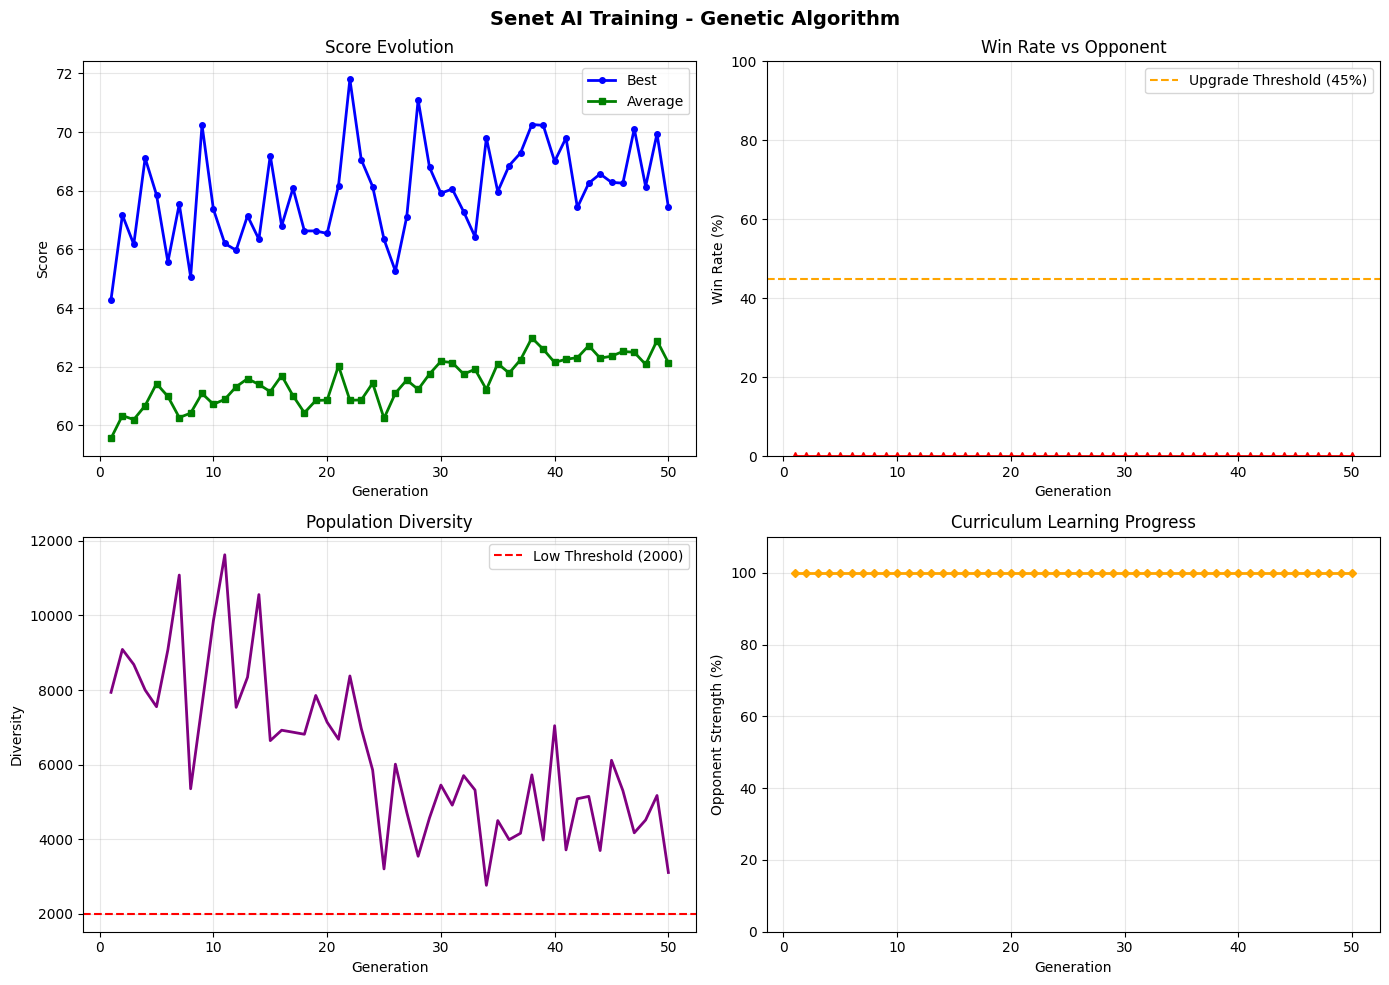

In [10]:
# ============================================================
# المدرب الرئيسي (مُصلح)
# ============================================================

class ImprovedTrainer:
    def __init__(self, project_name="senet-ai-evolution", opponent_checkpoint=None):
        self.population = []
        self.best_ever = None
        self.best_ever_score = -float('inf')
        self.stats = {
            'best_scores': [],
            'avg_scores': [],
            'diversity': [],
            'win_rates': [],           # ✅ FIX: جديد
            'opponent_strength': []     # ✅ FIX: جديد
        }
        self.start_gen = 0

        # Self-Play settings
        self.last_opponent_update_gen = 0
        self.opponent_update_interval = 5
        self.opponent_history = []

        self.opponent_strength = 1.0

        self.run_wandb = wandb.init(
            project=project_name,
            resume="allow",
            config={
                "pop_size": POP_SIZE,
                "gens": GENS,
                "matches_per_eval": MATCHES_PER_EVAL,
                "mutation_rate": MUTATION_RATE,
                "self_play": True,
                "initial_opponent_strength": self.opponent_strength
            }
        )

        # تحميل الخصم
        if opponent_checkpoint and os.path.exists(opponent_checkpoint):
            self.opponent_weights = self.load_opponent_from_checkpoint(opponent_checkpoint)
            print(f"✅ Loaded checkpoint as opponent")
        else:
            self.opponent_weights = SENET_AI_CONFIG.copy()
            print(f"✅ Starting with default AI opponent")
        
        print(f"🎮 Initial opponent strength: {self.opponent_strength*100:.0f}%")

    def _get_base_dna(self):
        return DESIRED_CONFIG_KEYS.copy()

    def _randomize_dna(self, base_dna=None):
        if base_dna is None:
            base_dna = self._get_base_dna()

        dna = {}
        for k, v in base_dna.items():
            factor = random.uniform(0.3, 2.0)  # ✅ FIX: زيادة التنوع
            dna[k] = v * factor
        return dna

    def _init_population(self):
        """✅ FIX: تهيئة العشيرة بتنوع أفضل"""
        print("Initializing population...")

        base = self._get_base_dna()

        # 20% بأوزان قريبة من الأصلية
        for _ in range(POP_SIZE // 5):
            dna = base.copy()
            for k in dna:
                dna[k] *= random.uniform(0.85, 1.15)
            self.population.append(dna)

        # 30% بتنوع متوسط
        for _ in range(POP_SIZE * 3 // 10):
            dna = base.copy()
            for k in dna:
                dna[k] *= random.uniform(0.5, 1.5)
            self.population.append(dna)

        # 50% بتنوع عالي
        while len(self.population) < POP_SIZE:
            self.population.append(self._randomize_dna())
        
        print(f"   Created {len(self.population)} individuals")

    def evaluate_dna(self, dna, dna_id):
        """
        ⚠️ هذه الدالة لم تعد تُستخدم مباشرة
        نستخدم evaluate_dna_worker بدلاً منها
        """
        pass

    def load_opponent_from_checkpoint(self, filepath):
        print(f"⚔️ Loading Opponent from: {filepath}")
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)

            opponent_weights = self._get_base_dna()

            if 'best_weights' in data:
                opponent_weights.update(data['best_weights'])
                print(f"   ✅ Opponent loaded with score: {data.get('best_score', 'N/A')}")
            else:
                print("   ⚠️ Warning: 'best_weights' not found. Using defaults.")

            # ✅ FIX: استعادة opponent_strength إذا موجود
            if 'opponent_strength' in data:
                # نبدأ من قيمة أقل قليلاً
                self.opponent_strength = max(0.1, data['opponent_strength'] * 0.5)
                print(f"   🎮 Adjusted opponent strength: {self.opponent_strength*100:.0f}%")

            return opponent_weights

        except FileNotFoundError:
            print(f"   ❌ File not found. Using default AI.")
            return SENET_AI_CONFIG.copy()

    def _mutate(self, dna, diversity=None):
        """✅ FIX: طفرة متكيفة مع التنوع"""
        new_dna = dna.copy()

        # ✅ FIX: تعديل معدل الطفرة حسب التنوع
        if diversity is not None and diversity < DIVERSITY_THRESHOLD:
            mutation_rate = 0.6
            mutation_strength = 0.4
        else:
            mutation_rate = MUTATION_RATE
            mutation_strength = 0.25

        num_mutations = random.randint(1, 4)

        for _ in range(num_mutations):
            if random.random() < mutation_rate:
                k = random.choice(list(new_dna.keys()))

                mutation_type = random.random()

                if mutation_type < 0.5:
                    # طفرة صغيرة
                    new_dna[k] *= random.uniform(1 - mutation_strength, 1 + mutation_strength)
                elif mutation_type < 0.85:
                    # طفرة متوسطة
                    new_dna[k] *= random.uniform(0.6, 1.4)
                else:
                    # طفرة كبيرة - إعادة تعيين
                    new_dna[k] = DESIRED_CONFIG_KEYS[k] * random.uniform(0.3, 2.0)

        return new_dna

    def _crossover(self, parent1, parent2):
        child = {}

        for k in DESIRED_CONFIG_KEYS.keys():
            method = random.random()
            
            if method < 0.4:
                child[k] = parent1.get(k, DESIRED_CONFIG_KEYS[k])
            elif method < 0.8:
                child[k] = parent2.get(k, DESIRED_CONFIG_KEYS[k])
            else:
                # ✅ FIX: Blend crossover
                avg = (parent1.get(k, DESIRED_CONFIG_KEYS[k]) + 
                       parent2.get(k, DESIRED_CONFIG_KEYS[k])) / 2
                child[k] = avg * random.uniform(0.9, 1.1)

        return child

    def _calculate_diversity(self):
        if len(self.population) < 2:
            return 0

        diversities = []
        sample_size = min(20, len(self.population))
        sample = random.sample(self.population, sample_size)
        
        for i in range(len(sample)):
            for j in range(i + 1, len(sample)):
                diff = sum(abs(sample[i].get(k, 0) - sample[j].get(k, 0))
                           for k in DESIRED_CONFIG_KEYS.keys())
                diversities.append(diff)

        return np.mean(diversities) if diversities else 0

    def _tournament_select(self, results, tournament_size=5):
        """✅ FIX: Tournament Selection"""
        candidates = random.sample(results, min(tournament_size, len(results)))
        best = max(candidates, key=lambda x: x[1])
        return best[3]

    def load_checkpoint(self, filepath):
        print(f"📂 Loading checkpoint from: {filepath}")
        with open(filepath, 'r') as f:
            data = json.load(f)

        fixed_best = self._get_base_dna()
        fixed_best.update(data.get('best_weights', {}))
        self.best_ever = fixed_best
        self.best_ever_score = data.get('best_score', -float('inf'))
        self.stats = data.get('stats', {
            'best_scores': [], 'avg_scores': [], 
            'diversity': [], 'win_rates': [], 'opponent_strength': []
        })

        if 'population' in data:
            self.population = []
            for old_dna in data['population']:
                fixed_dna = self._get_base_dna()
                fixed_dna.update(old_dna)
                self.population.append(fixed_dna)
        else:
            self.population = [self.best_ever.copy() for _ in range(POP_SIZE)]

        if 'opponent_weights' in data:
            self.opponent_weights = data['opponent_weights']
        if 'last_opponent_update' in data:
            self.last_opponent_update_gen = data['last_opponent_update']
        if 'opponent_history' in data:
            self.opponent_history = data['opponent_history']
        
        # ✅ FIX: استعادة opponent_strength
        # if 'opponent_strength' in data:
        #     self.opponent_strength = data['opponent_strength']

        self.start_gen = data['generation']

        print(f"✅ Resumed from Generation {self.start_gen}")
        print(f"   Best Score so far: {self.best_ever_score}")
        print(f"   Opponent strength: {self.opponent_strength*100:.0f}%")

    def run(self, resume_file=None):
        print("=" * 60)
        print("🧬 Self-Play Evolutionary Training (FIXED)")
        print(f"Population: {POP_SIZE}, Generations: {GENS}")
        print(f"Matches per eval: {MATCHES_PER_EVAL}")
        print(f"Initial opponent strength: {self.opponent_strength*100:.0f}%")
        print(f"Opponent updates every {self.opponent_update_interval} generations")
        print("=" * 60)

        if resume_file:
            self.load_checkpoint(resume_file)
        elif not self.population:
            self._init_population()

        for gen in range(self.start_gen, GENS):
            print(f"\n{'='*60}")
            print(f"Generation {gen + 1}/{GENS} | Opponent: {self.opponent_strength*100:.0f}%")
            print(f"{'='*60}")

            # ✅ FIX: تقييم كل العشيرة مع تمرير المعاملات صراحة
            eval_args = [
                (i, dna, self.opponent_weights.copy(), self.opponent_strength, MATCHES_PER_EVAL)
                for i, dna in enumerate(self.population)
            ]
            
            results = []
            with ProcessPoolExecutor(max_workers=4) as executor:
                futures = [executor.submit(evaluate_dna_worker, args) for args in eval_args]
                for future in as_completed(futures):
                    results.append(future.result())
                    print(f"  Evaluated {len(results)}/{len(self.population)} DNAs...", end='\r')

            print()

            # ترتيب حسب النقاط
            results.sort(key=lambda x: x[1], reverse=True)

            # إحصائيات
            scores = [r[1] for r in results]
            wins_list = [r[2] for r in results]
            
            best_score = scores[0]
            avg_score = np.mean(scores)
            worst_score = scores[-1]
            diversity = self._calculate_diversity()
            best_wins = wins_list[0]
            total_wins = sum(wins_list)

            # ✅ FIX: حساب win rates
            win_rate = best_wins / MATCHES_PER_EVAL
            pop_win_rate = total_wins / (POP_SIZE * MATCHES_PER_EVAL)

            self.stats['best_scores'].append(best_score)
            self.stats['avg_scores'].append(avg_score)
            self.stats['diversity'].append(diversity)
            self.stats['win_rates'].append(win_rate)
            self.stats['opponent_strength'].append(self.opponent_strength)

            # تحديث الأفضل على الإطلاق
            if best_score > self.best_ever_score:
                self.best_ever_score = best_score
                self.best_ever = results[0][3].copy()
                print(f"  🏆 NEW BEST EVER! Score: {best_score:.2f}")

            # ✅ FIX: طباعة محسّنة
            print(f"  📊 Best: {best_score:.2f} | Avg: {avg_score:.2f} | Worst: {worst_score:.2f}")
            print(f"  🎯 Best wins: {best_wins}/{MATCHES_PER_EVAL} ({win_rate*100:.1f}%)")
            print(f"  👥 Population wins: {total_wins}/{POP_SIZE * MATCHES_PER_EVAL} ({pop_win_rate*100:.1f}%)")
            print(f"  🧬 Diversity: {diversity:.2f}", end="")
            
            if diversity < DIVERSITY_THRESHOLD:
                print(" ⚠️ LOW!")
            else:
                print()

            # ===================================================
            # ✅ FIX: Curriculum Learning محسّن
            # ===================================================
            if (gen + 1) % self.opponent_update_interval == 0:
                if pop_win_rate >= 0.45:  # 45%+ من المجتمع يفوز
                    if self.opponent_strength < 1.0:
                        old_strength = self.opponent_strength
                        self.opponent_strength = min(1.0, self.opponent_strength + 0.12)
                        print(f"\n  📈 OPPONENT LEVEL UP! {old_strength*100:.0f}% → {self.opponent_strength*100:.0f}%")
                    
                    # تحديث أوزان الخصم عند قوة عالية
                    if self.opponent_strength >= 0.6:
                        print(f"  🔄 Updating opponent weights to current champion!")
                        self.opponent_weights = self.best_ever.copy()
                        self.opponent_history.append({
                            'gen': gen + 1,
                            'weights': self.best_ever.copy(),
                            'score': self.best_ever_score,
                            'strength': self.opponent_strength
                        })
                else:
                    print(f"\n  ⏳ Opponent update skipped (pop win rate {pop_win_rate*100:.1f}% < 45%)")
            # ===================================================
            # إنشاء الجيل الجديد
            # ===================================================
            new_population = []

            # 1. الاحتفاظ بالنخبة
            for _, _, _, dna in results[:ELITE_SIZE]:
                new_population.append(dna.copy())

            # 2. تهجين وطفرات
            while len(new_population) < POP_SIZE - 5:  # ✅ FIX: -5 للتنوع
                # ✅ FIX: Tournament Selection
                parent1 = self._tournament_select(results)
                parent2 = self._tournament_select(results)

                child = self._crossover(parent1, parent2)

                if random.random() < MUTATION_RATE:
                    child = self._mutate(child, diversity)

                new_population.append(child)

            # ✅ FIX: 3. حقن أفراد عشوائيين للتنوع
            num_random = 7 if diversity < DIVERSITY_THRESHOLD else 5
            while len(new_population) < POP_SIZE:
                new_population.append(self._randomize_dna())

            self.population = new_population[:POP_SIZE]

            if (gen + 1) % 5 == 0:
                self._save_checkpoint(gen + 1)

        # حفظ النتيجة النهائية
        print("\n" + "=" * 60)
        print("✅ Training Complete!")
        print(f"Best score achieved: {self.best_ever_score:.2f}")
        print(f"Final opponent strength: {self.opponent_strength*100:.0f}%")
        print(f"Opponent was updated {len(self.opponent_history)} times")
        print("=" * 60)

        self._save_final_result()
        self.plot_results()

    def _save_checkpoint(self, gen):
        filename = f"checkpoint_gen_{gen}.json"
        filepath = os.path.join(CHECKPOINT_DIR, filename)

        os.makedirs(CHECKPOINT_DIR, exist_ok=True)
        data = {
            'generation': gen,
            'best_weights': self.best_ever,
            'best_score': self.best_ever_score,
            'opponent_weights': self.opponent_weights,
            'opponent_strength': self.opponent_strength,  # ✅ FIX
            'last_opponent_update': self.last_opponent_update_gen,
            'opponent_history': self.opponent_history,
            'stats': self.stats,
            'population': self.population
        }
        with open(filepath, "w") as f:
            json.dump(data, f, indent=4)

        wandb.save(filepath, base_path=WORKING_DIR)
        wandb.log({
            "gen": gen,
            "best": self.best_ever_score,
            "avg": self.stats['avg_scores'][-1],
            "diversity": self.stats['diversity'][-1],
            "win_rate": self.stats['win_rates'][-1],
            "opponent_strength": self.opponent_strength
        })
        print(f"✅ Checkpoint saved: {filename}")

    def _save_final_result(self, filename="final_model_weights.json"):
        filepath = os.path.join(WORKING_DIR, filename)

        final_data = {
            "best_weights": self.best_ever,
            "best_score": self.best_ever_score,
            "opponent_strength": self.opponent_strength,
            "opponent_history": self.opponent_history,
            "stats": self.stats,
            "generation": GENS
        }

        with open(filepath, 'w') as f:
            json.dump(final_data, f, indent=4)
        print(f"💾 Final model saved: {filepath}")

        if wandb.run is not None:
            wandb.save(filepath, base_path=WORKING_DIR)
            artifact = wandb.Artifact(name="final_model", type="model")
            artifact.add_file(filepath)
            wandb.log_artifact(artifact)
            print(f"🚀 Uploaded to WandB!")

    def plot_results(self):
        """✅ FIX: رسم محسّن"""
        plot_path = os.path.join(WORKING_DIR, "learning_curve.png")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'training_progress_{timestamp}.png'

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        generations = list(range(1, len(self.stats['best_scores']) + 1))

        # 1. النقاط
        ax1 = axes[0, 0]
        ax1.plot(generations, self.stats['best_scores'], 'b-o', label='Best', linewidth=2, markersize=4)
        ax1.plot(generations, self.stats['avg_scores'], 'g-s', label='Average', linewidth=2, markersize=4)
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Score')
        ax1.set_title('Score Evolution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. معدل الفوز
        ax2 = axes[0, 1]
        if self.stats['win_rates']:
            ax2.plot(generations, [w*100 for w in self.stats['win_rates']], 'r-^', linewidth=2)
            ax2.axhline(y=45, color='orange', linestyle='--', label='Upgrade Threshold (45%)')
        ax2.set_xlabel('Generation')
        ax2.set_ylabel('Win Rate (%)')
        ax2.set_title('Win Rate vs Opponent')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)

        # 3. التنوع
        ax3 = axes[1, 0]
        ax3.plot(generations, self.stats['diversity'], 'purple', linewidth=2)
        ax3.axhline(y=DIVERSITY_THRESHOLD, color='red', linestyle='--', label=f'Low Threshold ({DIVERSITY_THRESHOLD})')
        ax3.set_xlabel('Generation')
        ax3.set_ylabel('Diversity')
        ax3.set_title('Population Diversity')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. قوة الخصم
        ax4 = axes[1, 1]
        if self.stats['opponent_strength']:
            ax4.plot(generations, [s*100 for s in self.stats['opponent_strength']], 'orange', linewidth=2, marker='D', markersize=4)
        ax4.set_xlabel('Generation')
        ax4.set_ylabel('Opponent Strength (%)')
        ax4.set_title('Curriculum Learning Progress')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 110)

        plt.suptitle('Senet AI Training - Genetic Algorithm', fontsize=14, fontweight='bold')
        plt.tight_layout()

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved: {filename}")

        if wandb.run is not None:
            wandb.log({"Learning Curve Plot": wandb.Image(plot_path)})
            wandb.save(plot_path)


def get_latest_checkpoint(drive_dir):
    files = glob.glob(os.path.join(drive_dir, "checkpoint_gen_*.json"))
    if not files:
        return None
    try:
        latest_file = max(files, key=lambda f: int(f.split('_gen_')[1].split('.')[0]))
        return latest_file
    except:
        return max(files, key=os.path.getmtime)


# ============================================================
# 🚀 التشغيل
# ============================================================
if __name__ == "__main__":
    # ✅ FIX: ابدأ من جديد بدون تحميل checkpoint قديم
    # لاختبار الإصلاحات
    
    print("\n🌱 Starting FRESH training with FIXED trainer...")
    trainer = ImprovedTrainer(project_name="senet-ai-evolution-fixed")
    trainer.run(None)
    
    # أو إذا أردت الاستمرار من checkpoint:
    # latest = get_latest_checkpoint(CHECKPOINT_DIR)
    # if latest:
    #     trainer = ImprovedTrainer(project_name="senet-ai-evolution-fixed", opponent_checkpoint=latest)
    #     trainer.run(latest)

In [11]:
# def auto_fetch_latest_checkpoint(entity="eliasnadder-liso", project="senet-ai-evolution"):
#     """
#     دالة ذكية تبحث تلقائياً عن آخر ملف حفظ في السحابة (WandB)
#     وإذا لم تجد، تبحث في الجهاز المحلي.
#     """
#     print(f"\n🔄 Auto-scanning for latest checkpoints...")

#     # 1. محاولة البحث في WandB (السحابة)
#     try:
#         api = wandb.Api()
#         # جلب الـ runs مرتبة من الأحدث للأقدم
#         runs = api.runs(f"{entity}/{project}", order="-created_at")

#         if runs:
#             print(f"   Connected to WandB. Scanning {len(runs)} runs...")

#             # البحث في أحدث 5 محاولات فقط لتوفير الوقت
#             for run in runs[:5]:
#                 files = [f for f in run.files() if "checkpoint_gen_" in f.name and f.name.endswith(".json")]

#                 if files:
#                     # العثور على الملف ذو الرقم الأكبر (أحدث جيل)
#                     latest_file = max(files, key=lambda f: int(f.name.split('_gen_')[1].split('.')[0]))

#                     print(f"   ⬇️  Found cloud checkpoint: Run '{run.name}' -> Gen {latest_file.name}")
#                     downloaded = latest_file.download(root=WORKING_DIR, replace=True)
#                     return downloaded.name
#     except Exception as e:
#         print(f"   ⚠️  Could not fetch from WandB: {e}")

#     # 2. محاولة البحث محلياً (Fallback)
#     print("   Checking local disk...")
#     local_checkpoint = get_latest_checkpoint(CHECKPOINT_DIR)

#     if local_checkpoint:
#         print(f"   📂 Found local checkpoint: {os.path.basename(local_checkpoint)}")
#         return local_checkpoint

#     return None

In [12]:
# if __name__ == "__main__":
#     # تهيئة المدرب

#     # البحث التلقائي عن آخر نقطة حفظ (سحابياً أو محلياً)
#     latest_checkpoint = auto_fetch_latest_checkpoint()
    
#     if latest_checkpoint:
#         print(f"\n🚀 AUTOMATIC RESTART: Resuming from {os.path.basename(latest_checkpoint)}")
#         trainer = ImprovedTrainer(project_name="senet-ai-evolution", opponent_checkpoint=latest_checkpoint)
#         trainer.run(None)
#         # مثال:
#         # تشغيل التدريب مباشرة بالملف المحمل
#         # الدالة run في الكلاس الخاص بك تتعامل تلقائياً مع تحميل الملف واستكمال الجيل
#         # trainer.run(latest_checkpoint)
        
#     else:
#         print("\n🌱 No history found. Starting FRESH training...")
#         trainer.run(None)

In [13]:

# def select_checkpoint_from_wandb(entity="eliasnadder-liso", project="senet-ai-evolution"):
#     print(f"\n🔄 Connecting to WandB Project: {entity}/{project}...")
#     api = wandb.Api()
#     try:
#         runs = api.runs(f"{entity}/{project}")
#     except Exception as e:
#         print(f"❌ Error connecting to WandB: {e}")
#         return None

#     # تصفية الـ Runs التي تحتوي على ملفات checkpoint فقط
#     available_runs = []
#     print("\n📊 Fetching runs data (this might take a moment)...")

#     for run in runs:
#         # نبحث عن الملفات التي تبدأ بـ checkpoint وتنتهي بـ json
#         files = [f for f in run.files() if "checkpoint_gen_" in f.name and f.name.endswith(".json")]

#         if files:
#             # نختار أحدث ملف بناءً على رقم الجيل في الاسم
#             # المتوقع: checkpoint_gen_10.json أو checkpoints/checkpoint_gen_10.json
#             try:
#                 latest_file = max(files, key=lambda f: int(f.name.split('_gen_')[1].split('.')[0]))

#                 # جلب معلومات إضافية للعرض
#                 best_score = run.summary.get('best', 'N/A')
#                 generation = run.summary.get('gen', 'N/A')

#                 available_runs.append({
#                     'run_name': run.name,
#                     'run_id': run.id,
#                     'best_score': best_score,
#                     'gen': generation,
#                     'file': latest_file,
#                     'created_at': run.created_at
#                 })
#             except:
#                 continue

#     if not available_runs:
#         print("⚠️ No runs with checkpoints found on WandB.")
#         return None

#     # عرض القائمة للمستخدم
#     print(f"\n{'Index':<6} | {'Run Name':<20} | {'Gen':<5} | {'Best Score':<10} | {'Date'}")
#     print("-" * 65)
#     for i, r in enumerate(available_runs):
#         date_str = r['created_at'][:10] # عرض التاريخ فقط
#         print(f"[{i}]    | {r['run_name']:<20} | {r['gen']:<5} | {r['best_score']:<10} | {date_str}")
#     print("-" * 65)

#     # طلب الاختيار من المستخدم
#     while True:
#         choice = input("\nSelect a run index to download (or 'q' to cancel): ").strip()
#         if choice.lower() == 'q':
#             return None

#         if choice.isdigit() and 0 <= int(choice) < len(available_runs):
#             selected = available_runs[int(choice)]
#             print(f"\n⬇️ Downloading checkpoint from run '{selected['run_name']}'...")

#             # تحميل الملف
#             file_ref = selected['file']
#             downloaded_file = file_ref.download(root=WORKING_DIR, replace=True)

#             # file_ref.download تُرجع stream، لذا نحدد المسار يدوياً للتأكيد
#             # wandb قد يحمل الملف داخل مجلدات فرعية، نحن بحاجة للمسار الكامل
#             local_path = downloaded_file.name

#             print(f"✅ Downloaded: {local_path}")
#             return local_path
#         else:
#             print("❌ Invalid selection. Try again.")

# def manual_weight_editor(weights):
#     """دالة تفاعلية لعرض وتعديل الأوزان يدوياً"""
#     current_weights = weights.copy()

#     while True:
#         print("\n📋 Current Weights Configuration:")
#         print(f"{'Key (ID)':<25} | {'Value':<10}")
#         print("-" * 40)

#         # تحويل المفاتيح لقائمة لسهولة الاختيار بالأرقام أو الأسماء
#         keys = list(current_weights.keys())
#         for i, k in enumerate(keys):
#             print(f"[{i+1:2d}] {k:<20} | {current_weights[k]:.2f}")
#         print("-" * 40)

#         print("\nOptions:")
#         print("  [enter]  Confirm and start training with these weights")
#         print("  [ID]     Enter number or name to modify a specific weight")

#         choice = input("Select option: ").strip()

#         if choice == "":
#             print("✅ Weights confirmed.")
#             return current_weights

#         selected_key = None

#         # التحقق هل المدخل رقم أم اسم
#         if choice.isdigit():
#             idx = int(choice) - 1
#             if 0 <= idx < len(keys):
#                 selected_key = keys[idx]
#         elif choice in current_weights:
#             selected_key = choice

#         if selected_key:
#             try:
#                 current_val = current_weights[selected_key]
#                 new_val_str = input(f"Enter new value for '{selected_key}' (Current: {current_val}): ").strip()
#                 new_val = float(new_val_str)
#                 current_weights[selected_key] = new_val
#                 print(f"✏️ Updated: {selected_key} = {new_val}")
#             except ValueError:
#                 print("❌ Invalid number format. No changes made.")
#         else:
#             print("❌ Invalid selection.")

# if __name__ == "__main__":
#     trainer = ImprovedTrainer()

#     print("\n🔍 Where do you want to load the checkpoint from?")
#     print("  [1] Local Disk (/kaggle/working/checkpoints)")
#     print("  [2] WandB Cloud (Select from project runs)")
#     print("  [3] Start Fresh (No Checkpoint)")

#     source_choice = input("Enter choice (1/2/3): ").strip()

#     checkpoint_path = None

#     # 1. البحث محلياً
#     if source_choice == '1':
#         checkpoint_path = get_latest_checkpoint(CHECKPOINT_DIR)
#         if not checkpoint_path:
#             print("⚠️ No local checkpoints found.")

#     # 2. البحث في WandB
#     elif source_choice == '2':
#         checkpoint_path = select_checkpoint_from_wandb()

#     # منطق التحميل والتعديل
#     if checkpoint_path:
#         print(f"\n🔔 Selected Checkpoint: {os.path.basename(checkpoint_path)}")
#         print("Options:")
#         print("  [r] Resume training (continue generation count)")
#         print("  [l] Load best weights & Restart (start gen 0 with these weights)")
#         print("  [n] Ignore and start NEW training")

#         action = input("Enter choice (r/l/n): ").strip().lower()

#         if action in ['r', 'l']:
#             # تحميل البيانات أولاً
#             print(f"📖 Reading checkpoint data...")
#             with open(checkpoint_path, 'r') as f:
#                 data = json.load(f)

#             # استخراج أفضل الأوزان المحفوظة
#             loaded_weights = data.get('best_weights', SENET_AI_CONFIG.copy())

#             # تصحيح التسمية القديمة إذا وجدت
#             if 'progress' in loaded_weights:
#                 loaded_weights['progress_base'] = loaded_weights.pop('progress')

#             # ====================================================
#             # 🛑 الميزة الجديدة: خيار التعديل قبل الاستخدام
#             # ====================================================
#             print("\n🧐 Do you want to review/edit the weights before starting?")
#             edit_choice = input("Press [y] to edit, or [Enter] to proceed as is: ").strip().lower()

#             if edit_choice == 'y':
#                 loaded_weights = manual_weight_editor(loaded_weights)

#             # تطبيق الأوزان (المعدلة أو الأصلية) على المدرب
#             trainer.best_ever = loaded_weights

#             if action == 'l':
#                 # خيار: Load Best & Restart
#                 print("🚀 Initializing new population based on (possibly modified) weights...")
#                 trainer.best_ever_score = data.get('best_score', -float('inf'))
#                 trainer.stats = {'best_scores': [], 'avg_scores': [], 'diversity': []}
#                 trainer.start_gen = 0

#                 # إنشاء عشيرة جديدة متمحورة حول هذه الأوزان
#                 trainer.population = []
#                 for _ in range(POP_SIZE):
#                     # نستخدم الأوزان (المعدلة) كأصل للطفرات
#                     mutated_dna = trainer._mutate(trainer.best_ever.copy())
#                     trainer.population.append(mutated_dna)

#                 trainer.run(None) # None لأننا قمنا بالإعداد يدوياً

#             elif action == 'r':
#                 # خيار: Resume
#                 print("🔄 Resuming training...")
#                 # استعادة بقية البيانات
#                 trainer.best_ever_score = data.get('best_score', -float('inf'))
#                 trainer.stats = data.get('stats', {'best_scores': [], 'avg_scores': [], 'diversity': []})
#                 trainer.start_gen = data['generation']

#                 # استعادة العشيرة القديمة
#                 if 'population' in data:
#                     trainer.population = []
#                     for old_dna in data['population']:
#                         # تصحيح سريع للتأكد من وجود كل المفاتيح
#                         fixed_dna = trainer._get_base_dna()
#                         fixed_dna.update(old_dna)
#                         trainer.population.append(fixed_dna)

#                     # 💡 ملاحظة ذكية: إذا عدل المستخدم الأوزان يدوياً في وضع الاستكمال (Resume)
#                     # فمن المنطقي استبدال أسوأ فرد في العشيرة القديمة بهذه الأوزان الجديدة
#                     # لضمان دخول تعديلاتك في دورة التطور فوراً
#                     if edit_choice == 'y':
#                         print("💡 Injecting modified weights into the population...")
#                         trainer.population[0] = trainer.best_ever.copy()
#                 else:
#                     # إذا لم تكن العشيرة موجودة، أنشئ واحدة جديدة من الأوزان
#                     trainer.population = [trainer.best_ever.copy() for _ in range(POP_SIZE)]

#                 trainer.run(None)

#         elif action == 'n':
#             print("⚠️ Starting fresh training...")
#             trainer.run(None)
#         else:
#             print("Invalid choice. Starting fresh training...")
#             trainer.run(None)
#     else:
#         # حالة عدم اختيار ملف أو عدم وجود ملفات
#         if source_choice in ['1', '2']:
#             print("Proceeding with fresh training since no checkpoint was selected.")
#         else:
#             print("Starting fresh training as requested.")
#         trainer.run(None)